# 라이브러리 불러오기

In [1]:
# ! pip install -U imbalanced-learn scikit-learn
# !pip install gensim
# ! pip install optuna

In [39]:
import numpy as np
import pandas as pd
import re
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
import matplotlib.pyplot as plt

from gensim.models import FastText
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import TreebankWordTokenizer # 표준 토큰화
from nltk.corpus import stopwords # 불용어 제거
from nltk.stem import WordNetLemmatizer # 기본 형태로 변환
from imblearn.under_sampling import NeighbourhoodCleaningRule # 비대칭이라 사용

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from tensorflow.keras.initializers import Constant
import optuna
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

# 데이터 불러오기

In [3]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission_df = pd.read_csv('./data/sample_submission.csv')

In [4]:
display(train_df.head())
display(test_df.head())

,ID,first_party,second_party,facts,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1


,ID,first_party,second_party,facts
0,TEST_0000,Salerno,United States,The 1984 Bail Reform Act allowed the federal c...
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",Lexecon Inc. was a defendant in a class action...
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.","In 2002 and 2003, Fox Television Stations broa..."
3,TEST_0003,Harold Kaufman,United States,During his trial for armed robbery of a federa...
4,TEST_0004,Berger,Hanlon,"In 1993, a magistrate judge issued a warrant a..."


In [5]:
train_df.groupby('first_party_winner').size()

first_party_winner
0     829
1    1649
dtype: int64

# 데이터 전처리

## 단어 처리

In [6]:
# 문자 처리
cat_cols = ['first_party', 'second_party', 'facts']

# \b : 단어 경계, W* : 길이가 0이상이고 단어가 아닌 문자, w{1} : 길이가 1인 단어
short_word = re.compile(r'\W*\b\w{1}\b') # 길이가 1인 단어 찾기
tokenizer = TreebankWordTokenizer() # 단어 단위로 토큰화
stopword = stopwords.words('english') # 불용어 리스트 가져오기
lemmatizer = WordNetLemmatizer() # 단어의 기본 형태 가져오기

In [7]:
def prepro1(df):
        df = df.strip() # 공백 제거
        df = df.lower() # 소문자로 변경
        df = df.replace(',', '')
        df = df.replace('.', '')
        

        content = short_word.sub('', df) # 한 글자 단어 제거
        com = re.compile(r"[^\uAC00-\uD7A30-9a-zA-Z\s]") # 한글, 영어, 숫자 및 공백 문자를 제외한 모든 문자를 매칭
        content = com.sub('', content)
        tokens = tokenizer.tokenize(content) # 단어 토큰화
        token_lst = []

        for token in tokens:
            if token not in stopword: #불용어 제거
                token_lst.append(lemmatizer.lemmatize(token, 'n')) # 단어의 기본 형태 가져오기
        return token_lst

In [8]:
train_df['first_party'] = train_df['first_party'].apply(prepro1)
train_df['second_party'] = train_df['second_party'].apply(prepro1)
train_df['facts'] = train_df['facts'].apply(prepro1)

test_df['first_party'] = test_df['first_party'].apply(prepro1)
test_df['second_party'] = test_df['second_party'].apply(prepro1)
test_df['facts'] = test_df['facts'].apply(prepro1)

In [9]:
all_text = train_df['first_party'].tolist() + train_df['second_party'].tolist() + train_df['facts'].tolist()

In [10]:
train_word_counts = train_df['facts'].apply(lambda x : len(str(x).split()))

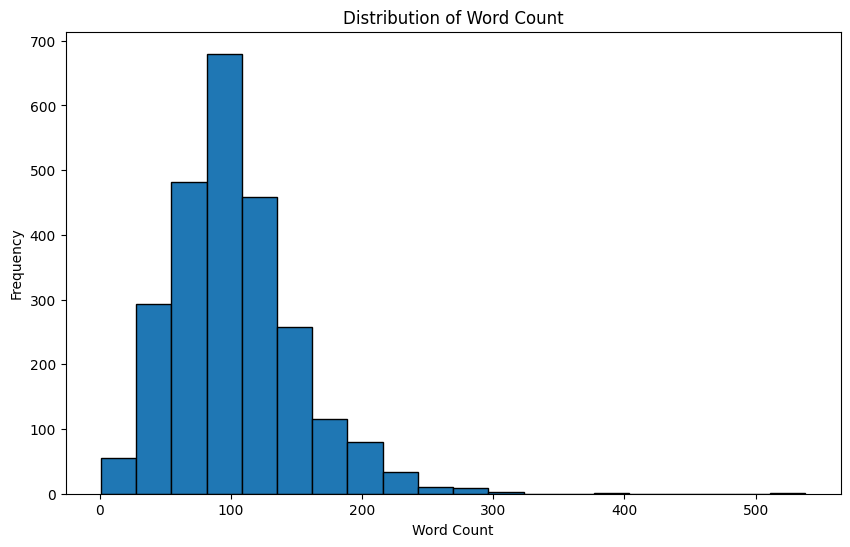

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(train_word_counts, bins=20, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count')
plt.show()

## fasttext

'FastText'를 사용해 사전 훈련된 단어 임베딩을 가져오고, 이를 사용해 keras의 임베딩 레이어를 초기화한다

=> FastText 모델에서 얻은 단어 임베딩을 임베딩 행렬로 저장하고 있습니다. 이러한 저장된 임베딩 행렬은 후에 모델을 구축할 때 사용

In [12]:
model = FastText(all_text, vector_size = 100, window = 5, min_count = 1, workers = 4, sg = 1)

# tokenizer를 사용해 단어 인덱스를 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_text)
word_index = tokenizer.word_index

In [13]:
embedding_dim = 100

In [14]:
# embedding matrix

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim)) # 단어 수 X 임베딩 차원

for word, i in word_index.items():
    if word in model.wv:
        embedding_vec = model.wv[word]
        embedding_matrix[i] = embedding_vec

In [15]:
# embeddings_initializer : 임베딩 레이어의 가중치를 초기화
# trainable = Fasle : 사전 훈련된 임베딩을 고정
embedding_layer = Embedding(len(word_index) + 1, embedding_dim, embeddings_initializer = Constant(embedding_matrix), trainable = False)

In [16]:
def get_vec(model, texts):
    vects = []
    
    for text in texts:
        text_vects = []
        for word in text:
            if word in model.wv.key_to_index:
                text_vects.append(model.wv.get_vector(word))
        if len(text_vects) > 0:
            text_vects = np.mean(text_vects, axis = 0)
            vects.append(text_vects)
        else:
            vects.append(np.zeros(model.vector_size))
    
    return np.array(vects)

In [17]:
X_train_first = get_vec(model, train_df['first_party'])
X_train_second = get_vec(model, train_df['second_party'])
X_train_facts = get_vec(model, train_df['facts'])

X_train = np.concatenate([X_train_first, X_train_second, X_train_facts], axis = 1)
y_train = train_df['first_party_winner']

In [18]:
X_test_first = get_vec(model, test_df['first_party'])
X_test_second = get_vec(model, test_df['second_party'])
X_test_facts = get_vec(model, test_df['facts'])

X_test = np.concatenate([X_test_first, X_test_second, X_test_facts], axis = 1)

## 불균형 데이터 처리

NeighbourhoodCleaningRule

불균형한 데이터셋에서 소수 클래스의 근접한 이웃을 고려하여 데이터를 정제하는 언더 샘플링 기법 중 하나
소수 클래스의 샘플을 중심으로 주변 이웃들을 찾는다

이웃들 중에서 다수 클래스에 속한 샘플들을 제거한다

이렇게 제거된 샘플들을 제외하고 남은 샘플들을 반환한다

In [19]:
X_ncr, y_ncr = NeighbourhoodCleaningRule(kind_sel = "all",  n_neighbors = 5).fit_resample(X_train, y_train)
print('train shape : {}, {}'.format(X_ncr.shape, y_ncr.shape))

train shape : (1415, 300), (1415,)


In [21]:
y_ncr.value_counts()

first_party_winner
0    829
1    586
Name: count, dtype: int64

## train데이터 셋으로 train, val 데이터 셋으로 분리

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_ncr, y_ncr, random_state = 123, test_size = 0.2, stratify = y_ncr)

print('Train shape : {}, {}'.format(X_train.shape, y_train.shape))
print(y_train.value_counts())

print()

print('Validation shape : {}, {}'.format(X_val.shape, y_val.shape))
print(y_val.value_counts())

Train shape : (1132, 300), (1132,)
first_party_winner
0    663
1    469
Name: count, dtype: int64

Validation shape : (283, 300), (283,)
first_party_winner
0    166
1    117
Name: count, dtype: int64


LSTM 모델은 일반적으로 시퀀스 데이터를 처리하기 위해 사용

첫 번째 축은 시간(또는 순서)을 나타내며, 두 번째 축은 각 시간 단계에서의 특성

In [26]:
# 차원 변경

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

In [28]:
X_train

array([[[ 0.17922319,  0.35275242, -0.00834119, ..., -0.27046925,
          0.28986067, -0.10465495]],

       [[ 0.2026282 ,  0.29483688, -0.00883478, ..., -0.20597169,
          0.16679136, -0.15688816]],

       [[ 0.14547916,  0.66807914, -0.03205763, ..., -0.15347184,
          0.15521765, -0.17586561]],

       ...,

       [[ 0.1254219 ,  0.38590807, -0.09176274, ..., -0.11243932,
          0.18681923, -0.16650443]],

       [[ 0.30307248,  0.30587134, -0.03059093, ..., -0.17328475,
          0.21388261, -0.18499412]],

       [[ 0.1627057 ,  0.60382318,  0.03230398, ..., -0.25519973,
          0.29735088, -0.04850616]]])

# 모델링

In [29]:
# Optuna를 사용하여 하이퍼파라미터 튜닝을 수행하기 위한 것

def objective(trial):
    units = trial.suggest_int('units', 32, 64, 128)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    optimizer = Adam(learning_rate = learning_rate)
    
    model = Sequential()
    model.add(LSTM(units, return_sequences = True, input_shape = (1, X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 50, verbose = 1)]
    model.fit(X_train, y_train, epochs = 100, batch_size = batch_size, validation_data = (X_val, y_val), verbose = 0, callbacks = callbacks)
    accuracy = model.evaluate(X_val, y_val, verbose = 0)[1]
    
    return accuracy

In [30]:
# objective 함수는 Optuna의 suggest_ 메서드를 사용하여 하이퍼파라미터 공간에서 샘플링하는 함수
study = optuna.create_study(direction = 'maximize')
# study 객체를 생성한 후 optimize 메서드를 사용하여 주어진 목적 함수(objective)를 최대화하는 방향으로 하이퍼파라미터를 조정
study.optimize(objective, n_trials = 50)

# Print the best hyperparameters and objective value
best_params = study.best_params
best_value = study.best_value
print("Best Parameters : ", best_params)
print("Best Value : ", best_value)

[I 2024-03-18 11:30:35,851] A new study created in memory with name: no-name-f77bdb17-eaf3-4f5d-b0c9-a2beea3303ec




Epoch 88: early stopping


[I 2024-03-18 11:30:57,410] Trial 0 finished with value: 0.6607773900032043 and parameters: {'units': 32, 'learning_rate': 0.001994945147226654, 'dropout_rate': 0.4347155132787126, 'batch_size': 16}. Best is trial 0 with value: 0.6607773900032043.
[I 2024-03-18 11:31:20,309] Trial 1 finished with value: 0.5865724086761475 and parameters: {'units': 32, 'learning_rate': 0.04516910998932426, 'dropout_rate': 0.2644945025720517, 'batch_size': 16}. Best is trial 0 with value: 0.6607773900032043.


Epoch 59: early stopping


[I 2024-03-18 11:31:35,510] Trial 2 finished with value: 0.5865724086761475 and parameters: {'units': 32, 'learning_rate': 0.07371196125187815, 'dropout_rate': 0.4379082552373829, 'batch_size': 16}. Best is trial 0 with value: 0.6607773900032043.


Epoch 80: early stopping


[I 2024-03-18 11:31:54,791] Trial 3 finished with value: 0.6254416704177856 and parameters: {'units': 32, 'learning_rate': 0.0005962607395902457, 'dropout_rate': 0.2846182135528775, 'batch_size': 16}. Best is trial 0 with value: 0.6607773900032043.
[I 2024-03-18 11:32:05,991] Trial 4 finished with value: 0.6325088143348694 and parameters: {'units': 32, 'learning_rate': 0.0010321762345920354, 'dropout_rate': 0.4357186528928512, 'batch_size': 64}. Best is trial 0 with value: 0.6607773900032043.


Epoch 82: early stopping


[I 2024-03-18 11:32:19,705] Trial 5 finished with value: 0.6254416704177856 and parameters: {'units': 32, 'learning_rate': 0.006331126615983055, 'dropout_rate': 0.399260067435765, 'batch_size': 32}. Best is trial 0 with value: 0.6607773900032043.
[I 2024-03-18 11:32:34,755] Trial 6 finished with value: 0.6219081282615662 and parameters: {'units': 32, 'learning_rate': 0.00015417438350135326, 'dropout_rate': 0.21836506219186985, 'batch_size': 32}. Best is trial 0 with value: 0.6607773900032043.
[I 2024-03-18 11:32:49,893] Trial 7 finished with value: 0.5865724086761475 and parameters: {'units': 32, 'learning_rate': 0.05465531661417403, 'dropout_rate': 0.09825889256577797, 'batch_size': 32}. Best is trial 0 with value: 0.6607773900032043.


Epoch 52: early stopping


[I 2024-03-18 11:32:59,875] Trial 8 finished with value: 0.5865724086761475 and parameters: {'units': 32, 'learning_rate': 0.08615021886790489, 'dropout_rate': 0.20903931104921464, 'batch_size': 32}. Best is trial 0 with value: 0.6607773900032043.
[I 2024-03-18 11:33:11,136] Trial 9 finished with value: 0.6537102460861206 and parameters: {'units': 32, 'learning_rate': 0.003848467772916731, 'dropout_rate': 0.41114243300583037, 'batch_size': 64}. Best is trial 0 with value: 0.6607773900032043.
[I 2024-03-18 11:33:34,657] Trial 10 finished with value: 0.5936395525932312 and parameters: {'units': 32, 'learning_rate': 1.090715764139948e-05, 'dropout_rate': 0.005195698704347995, 'batch_size': 16}. Best is trial 0 with value: 0.6607773900032043.


Epoch 94: early stopping


[I 2024-03-18 11:33:45,518] Trial 11 finished with value: 0.6431095600128174 and parameters: {'units': 32, 'learning_rate': 0.004898326032121862, 'dropout_rate': 0.3542689524698854, 'batch_size': 64}. Best is trial 0 with value: 0.6607773900032043.
[I 2024-03-18 11:33:56,838] Trial 12 finished with value: 0.6466431021690369 and parameters: {'units': 32, 'learning_rate': 0.005123827344544717, 'dropout_rate': 0.47971972999058254, 'batch_size': 64}. Best is trial 0 with value: 0.6607773900032043.
[I 2024-03-18 11:34:08,101] Trial 13 finished with value: 0.6289752721786499 and parameters: {'units': 32, 'learning_rate': 0.0008415595090809496, 'dropout_rate': 0.3438950718699404, 'batch_size': 64}. Best is trial 0 with value: 0.6607773900032043.


Epoch 55: early stopping


[I 2024-03-18 11:34:22,682] Trial 14 finished with value: 0.5865724086761475 and parameters: {'units': 32, 'learning_rate': 0.012305688301460744, 'dropout_rate': 0.4938533015368168, 'batch_size': 16}. Best is trial 0 with value: 0.6607773900032043.
[I 2024-03-18 11:34:34,257] Trial 15 finished with value: 0.6042402982711792 and parameters: {'units': 32, 'learning_rate': 0.00022295370005825937, 'dropout_rate': 0.3476500337962673, 'batch_size': 64}. Best is trial 0 with value: 0.6607773900032043.


Epoch 80: early stopping


[I 2024-03-18 11:34:55,369] Trial 16 finished with value: 0.6784452199935913 and parameters: {'units': 32, 'learning_rate': 0.002108477978608793, 'dropout_rate': 0.16493985479715922, 'batch_size': 16}. Best is trial 16 with value: 0.6784452199935913.
[I 2024-03-18 11:35:24,989] Trial 17 finished with value: 0.5936395525932312 and parameters: {'units': 32, 'learning_rate': 4.402383095974126e-05, 'dropout_rate': 0.14393186825015786, 'batch_size': 16}. Best is trial 16 with value: 0.6784452199935913.


Epoch 71: early stopping


[I 2024-03-18 11:35:46,832] Trial 18 finished with value: 0.6466431021690369 and parameters: {'units': 32, 'learning_rate': 0.0016462373771960023, 'dropout_rate': 0.11903986169480518, 'batch_size': 16}. Best is trial 16 with value: 0.6784452199935913.


Epoch 87: early stopping


[I 2024-03-18 11:36:08,133] Trial 19 finished with value: 0.6254416704177856 and parameters: {'units': 32, 'learning_rate': 0.0002576014004354475, 'dropout_rate': 0.044134632175572425, 'batch_size': 16}. Best is trial 16 with value: 0.6784452199935913.


Epoch 60: early stopping


[I 2024-03-18 11:36:23,904] Trial 20 finished with value: 0.5865724086761475 and parameters: {'units': 32, 'learning_rate': 0.02106482801021979, 'dropout_rate': 0.1767778790514675, 'batch_size': 16}. Best is trial 16 with value: 0.6784452199935913.


Epoch 98: early stopping


[I 2024-03-18 11:36:35,061] Trial 21 finished with value: 0.6537102460861206 and parameters: {'units': 32, 'learning_rate': 0.0022516053244330037, 'dropout_rate': 0.40835947952225504, 'batch_size': 64}. Best is trial 16 with value: 0.6784452199935913.


Epoch 78: early stopping


[I 2024-03-18 11:36:54,041] Trial 22 finished with value: 0.6501767039299011 and parameters: {'units': 32, 'learning_rate': 0.0027195417261343603, 'dropout_rate': 0.3260950144077912, 'batch_size': 16}. Best is trial 16 with value: 0.6784452199935913.
[I 2024-03-18 11:37:06,237] Trial 23 finished with value: 0.6183745861053467 and parameters: {'units': 32, 'learning_rate': 0.01148421422520176, 'dropout_rate': 0.295705639512808, 'batch_size': 64}. Best is trial 16 with value: 0.6784452199935913.
[I 2024-03-18 11:37:29,325] Trial 24 finished with value: 0.6254416704177856 and parameters: {'units': 32, 'learning_rate': 0.0006633320929721833, 'dropout_rate': 0.3879076202599142, 'batch_size': 16}. Best is trial 16 with value: 0.6784452199935913.


Epoch 79: early stopping


[I 2024-03-18 11:37:39,395] Trial 25 finished with value: 0.6643109321594238 and parameters: {'units': 32, 'learning_rate': 0.0028742913828141143, 'dropout_rate': 0.22823054144730515, 'batch_size': 64}. Best is trial 16 with value: 0.6784452199935913.


Epoch 87: early stopping


[I 2024-03-18 11:38:00,339] Trial 26 finished with value: 0.6148409843444824 and parameters: {'units': 32, 'learning_rate': 0.0003891408839922602, 'dropout_rate': 0.23191832978246962, 'batch_size': 16}. Best is trial 16 with value: 0.6784452199935913.


Epoch 82: early stopping


[I 2024-03-18 11:38:19,988] Trial 27 finished with value: 0.6289752721786499 and parameters: {'units': 32, 'learning_rate': 0.0015516172561769036, 'dropout_rate': 0.18563315802424527, 'batch_size': 16}. Best is trial 16 with value: 0.6784452199935913.
[I 2024-03-18 11:38:35,033] Trial 28 finished with value: 0.6395759582519531 and parameters: {'units': 32, 'learning_rate': 0.012066712921621935, 'dropout_rate': 0.14691249414715712, 'batch_size': 32}. Best is trial 16 with value: 0.6784452199935913.
[I 2024-03-18 11:38:46,352] Trial 29 finished with value: 0.6113074421882629 and parameters: {'units': 32, 'learning_rate': 9.102742184312588e-05, 'dropout_rate': 0.25808821769320095, 'batch_size': 64}. Best is trial 16 with value: 0.6784452199935913.


Epoch 79: early stopping


[I 2024-03-18 11:39:05,096] Trial 30 finished with value: 0.5971731543540955 and parameters: {'units': 32, 'learning_rate': 0.01692908794974532, 'dropout_rate': 0.08946575891426062, 'batch_size': 16}. Best is trial 16 with value: 0.6784452199935913.


Epoch 100: early stopping


[I 2024-03-18 11:39:17,281] Trial 31 finished with value: 0.6572437882423401 and parameters: {'units': 32, 'learning_rate': 0.00322745452067475, 'dropout_rate': 0.458433381732513, 'batch_size': 64}. Best is trial 16 with value: 0.6784452199935913.


Epoch 98: early stopping


[I 2024-03-18 11:39:28,380] Trial 32 finished with value: 0.6325088143348694 and parameters: {'units': 32, 'learning_rate': 0.0013374217968285123, 'dropout_rate': 0.4529431117128592, 'batch_size': 64}. Best is trial 16 with value: 0.6784452199935913.


Epoch 61: early stopping


[I 2024-03-18 11:39:37,006] Trial 33 finished with value: 0.5865724086761475 and parameters: {'units': 32, 'learning_rate': 0.03040965980816765, 'dropout_rate': 0.2793247540782834, 'batch_size': 64}. Best is trial 16 with value: 0.6784452199935913.
[I 2024-03-18 11:39:48,341] Trial 34 finished with value: 0.6395759582519531 and parameters: {'units': 32, 'learning_rate': 0.0028310966431793925, 'dropout_rate': 0.45463719027010735, 'batch_size': 64}. Best is trial 16 with value: 0.6784452199935913.


Epoch 84: early stopping


[I 2024-03-18 11:39:58,451] Trial 35 finished with value: 0.6289752721786499 and parameters: {'units': 32, 'learning_rate': 0.007474064757395894, 'dropout_rate': 0.300253347353541, 'batch_size': 64}. Best is trial 16 with value: 0.6784452199935913.
[I 2024-03-18 11:40:21,932] Trial 36 finished with value: 0.6537102460861206 and parameters: {'units': 32, 'learning_rate': 0.00048045080519399817, 'dropout_rate': 0.25073488074509215, 'batch_size': 16}. Best is trial 16 with value: 0.6784452199935913.


Epoch 71: early stopping


[I 2024-03-18 11:40:35,339] Trial 37 finished with value: 0.6042402982711792 and parameters: {'units': 32, 'learning_rate': 0.0010132143649413787, 'dropout_rate': 0.19751372339556716, 'batch_size': 32}. Best is trial 16 with value: 0.6784452199935913.


Epoch 85: early stopping


[I 2024-03-18 11:40:45,980] Trial 38 finished with value: 0.6431095600128174 and parameters: {'units': 32, 'learning_rate': 0.006773728420425243, 'dropout_rate': 0.15480038944622562, 'batch_size': 64}. Best is trial 16 with value: 0.6784452199935913.
[I 2024-03-18 11:41:08,887] Trial 39 finished with value: 0.6219081282615662 and parameters: {'units': 32, 'learning_rate': 0.0033931202581559882, 'dropout_rate': 0.3700503923665357, 'batch_size': 16}. Best is trial 16 with value: 0.6784452199935913.
[I 2024-03-18 11:41:23,840] Trial 40 finished with value: 0.6431095600128174 and parameters: {'units': 32, 'learning_rate': 0.0019705461211442913, 'dropout_rate': 0.4290810127162522, 'batch_size': 32}. Best is trial 16 with value: 0.6784452199935913.
[I 2024-03-18 11:41:36,115] Trial 41 finished with value: 0.6289752721786499 and parameters: {'units': 32, 'learning_rate': 0.0040986515946987165, 'dropout_rate': 0.41823600225575314, 'batch_size': 64}. Best is trial 16 with value: 0.6784452199935

Epoch 97: early stopping


[I 2024-03-18 11:41:47,244] Trial 42 finished with value: 0.5971731543540955 and parameters: {'units': 32, 'learning_rate': 0.008581439560501607, 'dropout_rate': 0.45548739220436574, 'batch_size': 64}. Best is trial 16 with value: 0.6784452199935913.
[I 2024-03-18 11:41:59,017] Trial 43 finished with value: 0.6042402982711792 and parameters: {'units': 32, 'learning_rate': 0.004016923673243832, 'dropout_rate': 0.4709536703675309, 'batch_size': 64}. Best is trial 16 with value: 0.6784452199935913.
[I 2024-03-18 11:42:10,286] Trial 44 finished with value: 0.6254416704177856 and parameters: {'units': 32, 'learning_rate': 0.001033139969867564, 'dropout_rate': 0.4897657183937966, 'batch_size': 64}. Best is trial 16 with value: 0.6784452199935913.


Epoch 79: early stopping


[I 2024-03-18 11:42:20,176] Trial 45 finished with value: 0.6254416704177856 and parameters: {'units': 32, 'learning_rate': 0.0022771996276766044, 'dropout_rate': 0.22430462550674882, 'batch_size': 64}. Best is trial 16 with value: 0.6784452199935913.
[I 2024-03-18 11:42:31,555] Trial 46 finished with value: 0.6289752721786499 and parameters: {'units': 32, 'learning_rate': 0.0007201761756224515, 'dropout_rate': 0.383370271828751, 'batch_size': 64}. Best is trial 16 with value: 0.6784452199935913.


Epoch 90: early stopping


[I 2024-03-18 11:42:52,498] Trial 47 finished with value: 0.6466431021690369 and parameters: {'units': 32, 'learning_rate': 0.0057934048147068795, 'dropout_rate': 0.3130730474728355, 'batch_size': 16}. Best is trial 16 with value: 0.6784452199935913.


Epoch 77: early stopping


[I 2024-03-18 11:43:05,311] Trial 48 finished with value: 0.6254416704177856 and parameters: {'units': 32, 'learning_rate': 0.0013788024386063938, 'dropout_rate': 0.442011331191742, 'batch_size': 32}. Best is trial 16 with value: 0.6784452199935913.
[I 2024-03-18 11:43:16,600] Trial 49 finished with value: 0.6643109321594238 and parameters: {'units': 32, 'learning_rate': 0.004632477040658721, 'dropout_rate': 0.39716284970679266, 'batch_size': 64}. Best is trial 16 with value: 0.6784452199935913.


Best Parameters :  {'units': 32, 'learning_rate': 0.002108477978608793, 'dropout_rate': 0.16493985479715922, 'batch_size': 16}
Best Value :  0.6784452199935913


In [34]:
model = Sequential()
model.add(LSTM(best_params['units'], return_sequences = True, input_shape = (1, X_train.shape[2])))
model.add(Dropout(best_params['dropout_rate']))
model.add(LSTM(best_params['units']))
model.add(Dropout(best_params['dropout_rate']))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
callbacks = [EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 50, verbose = 1)]

model.fit(X_train, y_train, epochs = 100, batch_size = best_params['batch_size'], validation_data = (X_val, y_val), callbacks = callbacks)

vector_size = X_train.shape[2]
X_test = X_test.reshape((X_test.shape[0], 1, vector_size))

pred = model.predict(X_test)


fpr, tpr, thresholds = roc_curve(y_val, model.predict(X_val).ravel())
gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)
print('Best Thresholds : {}'.format(thresholds[ix]))

Epoch 1/100
71/71 [==============================] - 4s 13ms/step - loss: 0.6823 - accuracy: 0.5822 - val_loss: 0.6757 - val_accuracy: 0.5866
Epoch 2/100
71/71 [==============================] - 0s 3ms/step - loss: 0.6719 - accuracy: 0.5857 - val_loss: 0.6651 - val_accuracy: 0.6007
Epoch 3/100
71/71 [==============================] - 0s 3ms/step - loss: 0.6614 - accuracy: 0.6131 - val_loss: 0.6684 - val_accuracy: 0.6007
Epoch 4/100
71/71 [==============================] - 0s 3ms/step - loss: 0.6483 - accuracy: 0.6254 - val_loss: 0.6685 - val_accuracy: 0.5972
Epoch 5/100
71/71 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.6263 - val_loss: 0.6521 - val_accuracy: 0.5936
Epoch 6/100
71/71 [==============================] - 0s 3ms/step - loss: 0.6466 - accuracy: 0.6237 - val_loss: 0.6610 - val_accuracy: 0.6042
Epoch 7/100
71/71 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.6352 - val_loss: 0.6497 - val_accuracy: 0.5936
Epoch 8/100


Epoch 59/100
71/71 [==============================] - 0s 3ms/step - loss: 0.4785 - accuracy: 0.7527 - val_loss: 0.7423 - val_accuracy: 0.6360
Epoch 60/100
71/71 [==============================] - 0s 3ms/step - loss: 0.4850 - accuracy: 0.7641 - val_loss: 0.7124 - val_accuracy: 0.6078
Epoch 61/100
71/71 [==============================] - 0s 3ms/step - loss: 0.4853 - accuracy: 0.7633 - val_loss: 0.6912 - val_accuracy: 0.6431
Epoch 62/100
71/71 [==============================] - 0s 3ms/step - loss: 0.4892 - accuracy: 0.7659 - val_loss: 0.6900 - val_accuracy: 0.6502
Epoch 63/100
71/71 [==============================] - 0s 3ms/step - loss: 0.4679 - accuracy: 0.7827 - val_loss: 0.7601 - val_accuracy: 0.6254
Epoch 64/100
71/71 [==============================] - 0s 3ms/step - loss: 0.4749 - accuracy: 0.7730 - val_loss: 0.7386 - val_accuracy: 0.6290
Epoch 65/100
71/71 [==============================] - 0s 3ms/step - loss: 0.4765 - accuracy: 0.7615 - val_loss: 0.6842 - val_accuracy: 0.6466
Epoch 

9/9 [==============================] - 0s 1ms/step


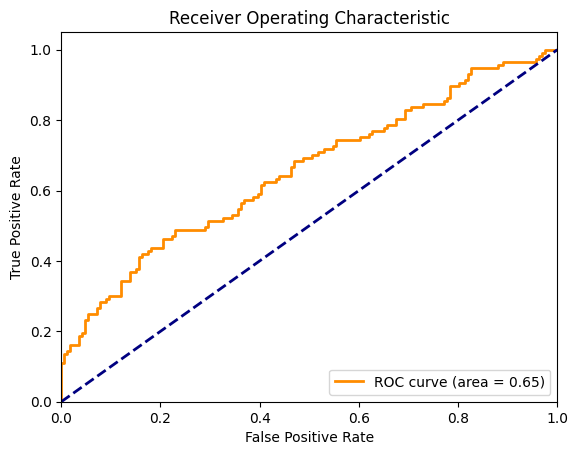

In [35]:
fpr, tpr, _ = roc_curve(y_val, model.predict(X_val).ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color = 'darkorange',
         lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")


In [36]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

9/9 [==============================] - 0s 1ms/step


In [37]:
y_train_pred = (y_train_pred > 0.5).astype(int)
y_val_pred = (y_val_pred > 0.5).astype(int)

In [40]:
print('train accuracy : ', accuracy_score(y_train, y_train_pred))
print('validation accuracy : ', accuracy_score(y_val, y_val_pred))

train accuracy :  0.8136042402826855
validation accuracy :  0.6537102473498233


# 제출

In [ ]:
y_pred = (pred > thresholds[ix]).astype(int).flatten()
submission_df['first_party_winner'] = y_pred
submission_df.to_csv('fasttext_lstm.csv', index = False)